In [46]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    # The book originally contained this unnecessary "else" clause:
    #else:
    #    with open(file_path, "r", encoding="utf-8") as file:
    #        text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [47]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [48]:

print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


In [49]:
def format_input(entry):
  instruction_text = (
      f"Below is an instruction that describes a task. "
      f"Write a response that appropriately completes the request. "
      f"\n\n ### Instruction: \n{entry['instruction']}"
  )

  input_text = f"\n\n ### Input: \n{entry['input']}" if entry["input"] else ""

  return instruction_text + input_text

In [50]:
model_input = format_input(data[50])
desired_response = f"\n\n ### Response: \n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request. 

 ### Instruction: 
Identify the correct spelling of the following word.

 ### Input: 
Ocassion

 ### Response: 
The correct spelling is 'Occasion.'


In [51]:
model_input = format_input(data[999])
desired_response = f"\n\n ### Response: \n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request. 

 ### Instruction: 
What is an antonym of 'complicated'?

 ### Response: 
An antonym of 'complicated' is 'simple'.


In [52]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [53]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


In [69]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
  def __init__(self,data,tokenizer):
    self.data = data

    self.encoded_text = []
    for entry in data:
      instruction_plus_input = format_input(entry)
      response_text = f"\n\n ### Response: \n{entry['output']}"
      full_text = instruction_plus_input + response_text
      self.encoded_text.append(tokenizer.encode(full_text)) # Use tokenizer.encode() here

  def __getitem__(self,index):
    return self.encoded_text[index]

  def __len__(self):
    return len(self.data)

In [70]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>",allowed_special= {"<|endoftext|>"}))

[50256]


In [71]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [72]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [73]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [74]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [75]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [76]:
inputs,targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [77]:
logits_1 = torch.tensor(
    [[-1.0,1.0],
     [-0.5,1.5]]
)

targets_1 = torch.tensor([0,1])

loss_1 = torch.nn.functional.cross_entropy(logits_1,targets_1)
print(loss_1)

tensor(1.1269)


In [78]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [79]:
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [81]:
print("Device:", device)

Device: cuda


In [82]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [83]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [84]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [85]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)


Train loader:
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 74]) torch.Size([8, 74])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 78]) torch.Size([8, 78])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 84]) torch.Size([8, 84])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 69]) torch.

In [86]:

print(inputs[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   220,   628,
        44386, 46486,    25,   220,   198, 30003,  6525,   262,  6827,  1262,
          257,   985,   576,    13,   628, 44386, 23412,    25,   220,   198,
          464,  5156,   318,   845, 13779,    13,   628, 44386, 18261,    25,
          220,   198,   464,  5156,   318,   355, 13779,   355,   257,  4936,
           13, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
       device='cuda:0')


In [88]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 81.1kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 2.42MiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 140kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [01:52<00:00, 12.6MiB/s]
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 15.1MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:00<00:00, 2.42MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.63MiB/s]


In [89]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request. 

 ### Instruction: 
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [90]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [91]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

The active sentence is the sentence that is being processed. The passive sentence is the sentence that is being processed.
The active sentence is the sentence that is being processed.


In [92]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)

In [93]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.8631935596466063
Validation loss: 3.778960847854614


In [94]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.853, Val loss 2.835
Ep 1 (Step 000005): Train loss 1.163, Val loss 1.099
Ep 1 (Step 000010): Train loss 0.845, Val loss 0.942
Ep 1 (Step 000015): Train loss 0.846, Val loss 0.905
Ep 1 (Step 000020): Train loss 0.769, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.755, Val loss 0.851
Ep 1 (Step 000030): Train loss 0.789, Val loss 0.829
Ep 1 (Step 000035): Train loss 0.708, Val loss 0.801
Ep 1 (Step 000040): Train loss 0.662, Val loss 0.799
Ep 1 (Step 000045): Train loss 0.622, Val loss 0.783
Ep 1 (Step 000050): Train loss 0.659, Val loss 0.775
Ep 1 (Step 000055): Train loss 0.745, Val loss 0.757
Ep 1 (Step 000060): Train loss 0.701, Val loss 0.734
Ep 1 (Step 000065): Train loss 0.632, Val loss 0.723
Ep 1 (Step 000070): Train loss 0.523, Val loss 0.720
Ep 1 (Step 000075): Train loss 0.562, Val loss 0.721
Ep 1 (Step 000080): Train loss 0.590, Val loss 0.711
Ep 1 (Step 000085): Train loss 0.501, Val loss 0.697
Ep 1 (Step 000090): Train loss 0.543, Val loss

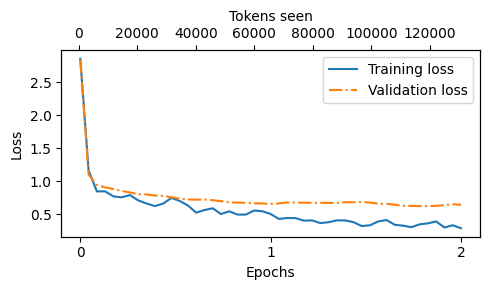

In [95]:
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [98]:
torch.manual_seed(123)

for entry in test_data[:3]:

  input_text = format_input(entry)

  token_ids = generate(
      model = model,
      idx = text_to_token_ids(input_text,tokenizer).to(device),
      max_new_tokens = 256,
      context_size = BASE_CONFIG['context_length'],
      eos_id = 50256
  )
  generated_text = token_ids_to_text(token_ids,tokenizer)
  response_text  = (
      generated_text[len(input_text):]
      .replace("### Response: ", "")
      .strip()
  )

  print(input_text)
  print(f"\nCorrect response:\n>> {entry['output']}")
  print(f"\nModel response:\n>> {response_text.strip()}")
  print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request. 

 ### Instruction: 
Rewrite the sentence using a simile.

 ### Input: 
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request. 

 ### Instruction: 
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A thunderstorm is a type of cumulus cloud that is formed when thunderstorms produce a dense, fast-moving, and intense updraft that causes the surface of the cloud to rise rapidly.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request. 

 ### Instruction: 
Na

In [99]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [01:14<00:00,  1.47it/s]


In [100]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a cheetah.'}


In [101]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-sft.pth
